# Train Spending Forecaster — UniGuard Wallet

This notebook trains the **Spending Forecaster** model from scratch for UniGuard Wallet,
using **multiple Kaggle spending/transactions datasets**, then fitting a
**Gradient Boosting Regressor** on the full cleaned data.

## End-to-end steps in this notebook

1. **Set up paths and imports**  
   - Configure `PROJECT_ROOT` and `BACKEND_ROOT`.  
   - Import the shared training pipeline from `backend/training/` (`pipeline`, `train_models`).

2. **Select the model**  
   - Set `MODEL_NAME = "spending_forecaster"` so all pipeline steps run for this model.

3. **Download all Kaggle datasets for this model**  
   - Uses `backend/training/models/spending_forecaster/datasets.json` and
     `DEFAULT_DATASET_PATHS` in `backend/training/train_models.py`.  
   - Currently pulls from several Kaggle sources, including:
     - `ismetsemedov/personal-budget-transactions-dataset`
     - `mohammedarfathr/budgetwise-personal-finance-dataset`
     - `cihannl/budgetwise-personal-finance-dataset`
     - `thedevastator/analyzing-credit-card-spending-habits-in-india`
   - `pipeline.download_datasets(...)` downloads each dataset via `kagglehub` and writes
     a **manifest**: `backend/training/data/datasets_manifest.json`.

4. **Export cleaned, merged spending dataset**  
   - `pipeline.export_clean(MODEL_NAME)`:
     - Reads all configured Kaggle sources for this model.  
     - Normalizes dates, categories, amounts, filters low-quality data.
     - Aggregates into a combined spending time series.  
     - Writes: `backend/training/models/spending_forecaster/cleaned/spending_clean.csv`.

5. **Save a copy of the cleaned dataset next to this notebook**  
   - The `# 2b` cell copies `spending_clean.csv` to:
     - `notebooks/spending_forecaster_clean.csv`

6. **Inspect spending statistics and evaluate the rule-based (simulated) forecaster**  
   - Build the dataset again via `train_models.build_spending_dataset()`.  
   - Print shape, category distributions, and sample rows.  
   - Run `train_models.evaluate_spending_forecaster(...)` to compute:
     - `samples`, `MAE`, `MAPE`, `directional_accuracy`.

7. **(Optional) Visualize metrics and category distributions**  
   - Plot bar charts of MAE/MAPE and top spending categories.

8. **Train the best ML algorithm (Gradient Boosting Regressor) on full cleaned data**  
   - Load `notebooks/spending_forecaster_clean.csv`.  
   - Derive a `month` feature from the `date` column.  
   - Build a `sklearn` pipeline with:
     - `ColumnTransformer` (OneHot + StandardScaler) over `category` and `month`.  
     - `GradientBoostingRegressor` as the final model.  
   - Fit on a train/test split and print final **MAE** and **MAPE**.  
   - Save the trained model as:
     - `notebooks/spending_forecaster_gb.pkl`

To train with **even more Kaggle data**, add new dataset IDs to
`backend/training/models/spending_forecaster/datasets.json`, re-run the download and
cleaning cells, then re-run the training cell at the bottom of this notebook.


## End-to-end pipeline for this model

This notebook trains the **Spending Forecaster** from scratch using **multiple Kaggle datasets** and the shared Python training pipeline.

**The full sequence of steps is:**

1. **Configure Kaggle datasets** (in `backend/training/models/spending_forecaster/datasets.json`).
2. **Load and display dataset list** via `pipeline.load_model_datasets(MODEL_NAME)`.
3. **Download all Kaggle datasets** with `pipeline.download_datasets(...)` (updates `datasets_manifest.json`).
4. **Build and export cleaned time‑series data** using `pipeline.export_clean(MODEL_NAME)`.
5. **Save a copy of the cleaned CSV** next to this notebook (`notebooks/spending_forecaster_clean.csv`).
6. **Build the full spending dataset** in memory using `train_models.build_spending_dataset()`.
7. **Compute statistics and evaluation metrics** on real data using `train_models.evaluate_spending_forecaster(...)`.
8. **Train a final Gradient Boosting regressor** on the full cleaned dataset and save it as `spending_forecaster_gb.pkl`.
9. **Generate graphs** for model metrics and category distributions.

You can add more Kaggle datasets to the JSON config, then re‑run all cells to retrain with more data.

In [1]:
import sys
from pathlib import Path

# Adjust this if you move the repo
PROJECT_ROOT = Path("/home/mukama/Desktop/finance 2 (Copy)").resolve()
BACKEND_ROOT = PROJECT_ROOT / "backend"

if str(BACKEND_ROOT) not in sys.path:
    sys.path.append(str(BACKEND_ROOT))

from training import pipeline, train_models

print("PROJECT_ROOT:", PROJECT_ROOT)
print("BACKEND_ROOT:", BACKEND_ROOT)
print("Artifacts dir (TS) will be:", (PROJECT_ROOT / "frontend" / "src" / "lib" / "ai" / "models" / "artifacts"))


PROJECT_ROOT: /home/mukama/Desktop/finance 2 (Copy)
BACKEND_ROOT: /home/mukama/Desktop/finance 2 (Copy)/backend
Artifacts dir (TS) will be: /home/mukama/Desktop/finance 2 (Copy)/frontend/src/lib/ai/models/artifacts


In [3]:
# This notebook is dedicated to the spending forecaster model.
MODEL_NAME = "spending_forecaster"
print("Current model:", MODEL_NAME)


Current model: spending_forecaster


In [4]:
# 1) Download datasets for the spending forecaster (Kaggle)

datasets = pipeline.load_model_datasets(MODEL_NAME)
if not datasets:
    raise SystemExit(f"No datasets configured for model '{MODEL_NAME}'. Check backend/training/models/{MODEL_NAME}/datasets.json")

print("Datasets to download:")
for d in datasets:
    print("  -", d)

manifest = pipeline.download_datasets(datasets)
print("\nDownload manifest written to:", pipeline.MANIFEST_PATH)
manifest


Datasets to download:
  - ismetsemedov/personal-budget-transactions-dataset
  - mohammedarfathr/budgetwise-personal-finance-dataset
  - cihannl/budgetwise-personal-finance-dataset
  - thedevastator/analyzing-credit-card-spending-habits-in-india


/home/mukama/Desktop/finance 2 (Copy)/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloaded mohammedarfathr/budgetwise-personal-finance-dataset -> /home/mukama/.cache/kagglehub/datasets/mohammedarfathr/budgetwise-personal-finance-dataset/versions/2
Downloaded cihannl/budgetwise-personal-finance-dataset -> /home/mukama/.cache/kagglehub/datasets/cihannl/budgetwise-personal-finance-dataset/versions/1
Downloaded thedevastator/analyzing-credit-card-spending-habits-in-india -> /home/mukama/.cache/kagglehub/datasets/thedevastator/analyzing-credit-card-spending-habits-in-india/versions/3

Download manifest written to: /home/mukama/Desktop/finance 2 (Copy)/backend/training/data/datasets_manifest.json


{'ismetsemedov/personal-budget-transactions-dataset': '/home/mukama/.cache/kagglehub/datasets/ismetsemedov/personal-budget-transactions-dataset/versions/4',
 'mohammedarfathr/budgetwise-personal-finance-dataset': '/home/mukama/.cache/kagglehub/datasets/mohammedarfathr/budgetwise-personal-finance-dataset/versions/2',
 'cihannl/budgetwise-personal-finance-dataset': '/home/mukama/.cache/kagglehub/datasets/cihannl/budgetwise-personal-finance-dataset/versions/1',
 'thedevastator/analyzing-credit-card-spending-habits-in-india': '/home/mukama/.cache/kagglehub/datasets/thedevastator/analyzing-credit-card-spending-habits-in-india/versions/3'}

In [5]:
# 2) Export cleaned datasets for this model (optional but recommended)

pipeline.export_clean(MODEL_NAME)
print("Cleaned data exported under:", (pipeline.MODELS_DIR / MODEL_NAME / "cleaned"))


/home/mukama/Desktop/finance 2 (Copy)/backend/training/train_models.py:882: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  subset["date"] = pd.to_datetime(subset["date"], errors="coerce")
/home/mukama/Desktop/finance 2 (Copy)/backend/training/train_models.py:905: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M").astype(str)


Cleaned data written to: /home/mukama/Desktop/finance 2 (Copy)/backend/training/models/spending_forecaster/cleaned
Cleaned data exported under: /home/mukama/Desktop/finance 2 (Copy)/backend/training/models/spending_forecaster/cleaned


In [6]:
# 2b) Save cleaned dataset next to this notebook

from pathlib import Path
import shutil

NOTEBOOK_DIR = PROJECT_ROOT / "notebooks"
SRC_DIR = pipeline.MODELS_DIR / MODEL_NAME / "cleaned"
SRC_FILE = SRC_DIR / "spending_clean.csv"
DST_FILE = NOTEBOOK_DIR / "spending_forecaster_clean.csv"

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)

if SRC_FILE.exists():
    shutil.copy(SRC_FILE, DST_FILE)
    print("Saved cleaned dataset copy to:", DST_FILE)
else:
    print("Cleaned source file not found:", SRC_FILE)
    print("Make sure you ran the 'export cleaned datasets' cell first.")

Saved cleaned dataset copy to: /home/mukama/Desktop/finance 2 (Copy)/notebooks/spending_forecaster_clean.csv


In [7]:
# 3) Data statistics and evaluation on real data

# Build the spending dataset exactly as the training pipeline does
spending = train_models.build_spending_dataset()
print("Spending dataset shape:", spending.shape)
print("Columns:", list(spending.columns))

if not spending.empty:
    print("\nCategory distribution (top 15):")
    print(spending["category"].value_counts().head(15))

    print("\nSample rows:")
    display(spending.head())

# Evaluate the spending forecaster on a hold-out split of the real data
metrics = train_models.evaluate_spending_forecaster(spending)

print("\nEvaluation metrics on real data (recomputed each run):")
for key, value in metrics.items():
    print(f"  {key}: {value}")

Spending dataset shape: (6814, 3)
Columns: ['date', 'category', 'amount']

Category distribution (top 15):
category
Food             2966
Eating Out       1491
Transport        1409
Communication     396
Miscellaneous     271
Shopping          141
Health            140
Name: count, dtype: int64

Sample rows:


/home/mukama/Desktop/finance 2 (Copy)/backend/training/train_models.py:882: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  subset["date"] = pd.to_datetime(subset["date"], errors="coerce")
/home/mukama/Desktop/finance 2 (Copy)/backend/training/train_models.py:905: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M").astype(str)


,date,category,amount
0,2022-07-06 05:57:10+00:00,Eating Out,5.50
1,2022-07-06 05:57:27+00:00,Food,2.00
2,2022-07-06 05:58:25+00:00,Food,17.33
3,2022-07-06 05:59:00+00:00,Eating Out,5.50
4,2022-07-06 05:59:15+00:00,Food,11.78



Evaluation metrics on real data (recomputed each run):
  samples: 47
  mae: 431.295
  mape: 12.7362
  directional_accuracy: 0.525


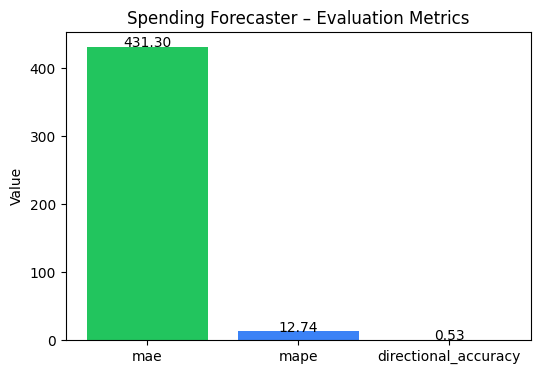

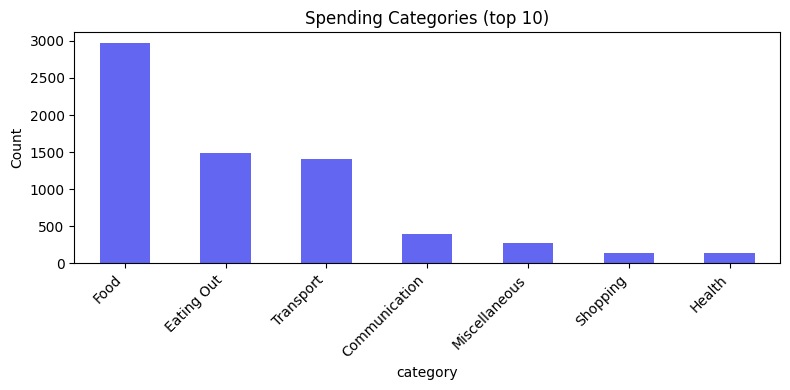

In [8]:
# 4) Visualize model performance and data (graphs)

import matplotlib.pyplot as plt

# --- Metric bar chart ---
metric_keys = ["mae", "mape", "directional_accuracy"]
metric_vals = [float(metrics.get(k, 0.0)) for k in metric_keys]

plt.figure(figsize=(6, 4))
plt.bar(metric_keys, metric_vals, color=["#22c55e", "#3b82f6", "#a855f7"])
plt.ylabel("Value")
plt.title("Spending Forecaster – Evaluation Metrics")
for i, v in enumerate(metric_vals):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.show()

# --- Category distribution (top 10) ---
if "spending" in globals() and not spending.empty:
    top_cats = spending["category"].value_counts().head(10)
    plt.figure(figsize=(8, 4))
    top_cats.plot(kind="bar", color="#6366f1")
    plt.title("Spending Categories (top 10)")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [9]:
# 3) Train the spending forecaster and write TS artifacts

# Ensure training code sees the latest dataset manifest
train_models.DATASET_PATHS = train_models.resolve_dataset_paths()

print(f"Running training for model: {MODEL_NAME}")
train_models.run_training(MODEL_NAME)

print("\nTraining complete. Artifacts should now be in:")
print(PROJECT_ROOT / "frontend" / "src" / "lib" / "ai" / "models" / "artifacts")


Running training for model: spending_forecaster
Artifacts written to: /home/mukama/Desktop/finance 2 (Copy)/frontend/src/lib/ai/models/artifacts

Training complete. Artifacts should now be in:
/home/mukama/Desktop/finance 2 (Copy)/frontend/src/lib/ai/models/artifacts


/home/mukama/Desktop/finance 2 (Copy)/backend/training/train_models.py:882: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  subset["date"] = pd.to_datetime(subset["date"], errors="coerce")
/home/mukama/Desktop/finance 2 (Copy)/backend/training/train_models.py:905: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M").astype(str)


In [ ]:
# placeholder